# 量子ハードウェア

<Admonition type="note">
  Masao Tokunari and Tamiya Onodera (14 June 2024)

  このコースは、東京大学で提供された授業に基づいています。

  和訳版の講義スライドPDFは[こちら](https://github.com/quantum-tokyo/introduction/blob/main/src/courses/utility-scale-quantum-computing/9_hardware_ja.pdf)です。

  このレッスンの講義 PDF は 2 つの部分に分かれています。[パート1をダウンロード](https://ibm.box.com/shared/static/ruz8wf353hncenmaywjlfjilflaumnzt.zip) と [パート 2 をダウンロード](https://ibm.box.com/shared/static/tg8vv00ern2bmxmm033xt9oe0fcvwamc.zip) を参照してください。コードは非推奨になる可能性があることに注意してください。
</Admonition>



## 1. はじめに

このレッスンでは、最新の量子コンピューティング ハードウェアについて説明します。

まず、いくつかのバージョンを確認し、関連するパッケージをインポートします。


In [1]:
import statistics

from qiskit_ibm_runtime import QiskitRuntimeService

## 2. バックエンドとターゲット

Qiskitは、量子デバイスに関する静的および動的の両方の情報を取得するためのAPIを提供します。バックエンド・インスタンスを使用してデバイスとのインターフェースに使用します。ターゲット・インスタンスは、命令セットアーキテクチャ(ISA)やそれに関連するプロパティや制約などの関連機能を要約した抽象マシンモデルです。
これらのバックエンド・インスタンスを使用して、IBM Quantum Platform® に表示される[Compute resources](https://quantum.cloud.ibm.com/computers)ページの情報の一部を取得しましょう。
まず、目的のデバイスのバックエンド・インスタンスを作成します。 以下では、 "ibm\_kyoto" 、"ibm\_kawasaki"、または最もビジーの少ない Eagle マシンを選択します。QPU へのアクセスは異なる場合があります。それに応じてバックエンド名を更新します。


In [2]:
service = QiskitRuntimeService()
service.backends()

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]

In [3]:
service = QiskitRuntimeService()
# backend = service.backend("ibm_kawasaki") # an Eagle, if you have access to ibm_kawasaki
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)  # Eagle
backend.name

'ibm_torino'

(訳註) 現在使える Eagle マシンを選択します。

In [4]:
backend = service.backend("ibm_brisbane") 

デバイスに関するいくつかの基本的な(静的)情報から始めます。


In [5]:
print(
    f"""
{backend.name}, {backend.num_qubits} qubits
processor type = {backend.processor_type}
basis gates = {backend.basis_gates}
"""
)


ibm_brisbane, 127 qubits
processor type = {'family': 'Eagle', 'revision': 3}
basis gates = ['ecr', 'id', 'rz', 'sx', 'x']



### 2.1 演習

Heron デバイスに関する基本情報 "ibm\_torino" を取得してみてください。自分で確認できるようにコードが以下に追加されています。


In [6]:
a_heron = service.backend("ibm_torino")  # a Heron

# your code here
print(
    f"""
{backend.name}, {a_heron.num_qubits} qubits
processor type = {a_heron.processor_type}
basis gates = {a_heron.basis_gates}
"""
)


ibm_brisbane, 133 qubits
processor type = {'family': 'Heron', 'revision': '1'}
basis gates = ['cz', 'id', 'rz', 'sx', 'x']



### 2.2 カップリングマップ

次に、デバイスのカップリングマップを描画します。ご覧のとおり、ノードは番号が付けられた量子ビットです。エッジは、2 量子ビットのエンタングルゲートを直接適用できるペアを示します。このトポロジーは "heavy-hex 格子" と呼ばれます。

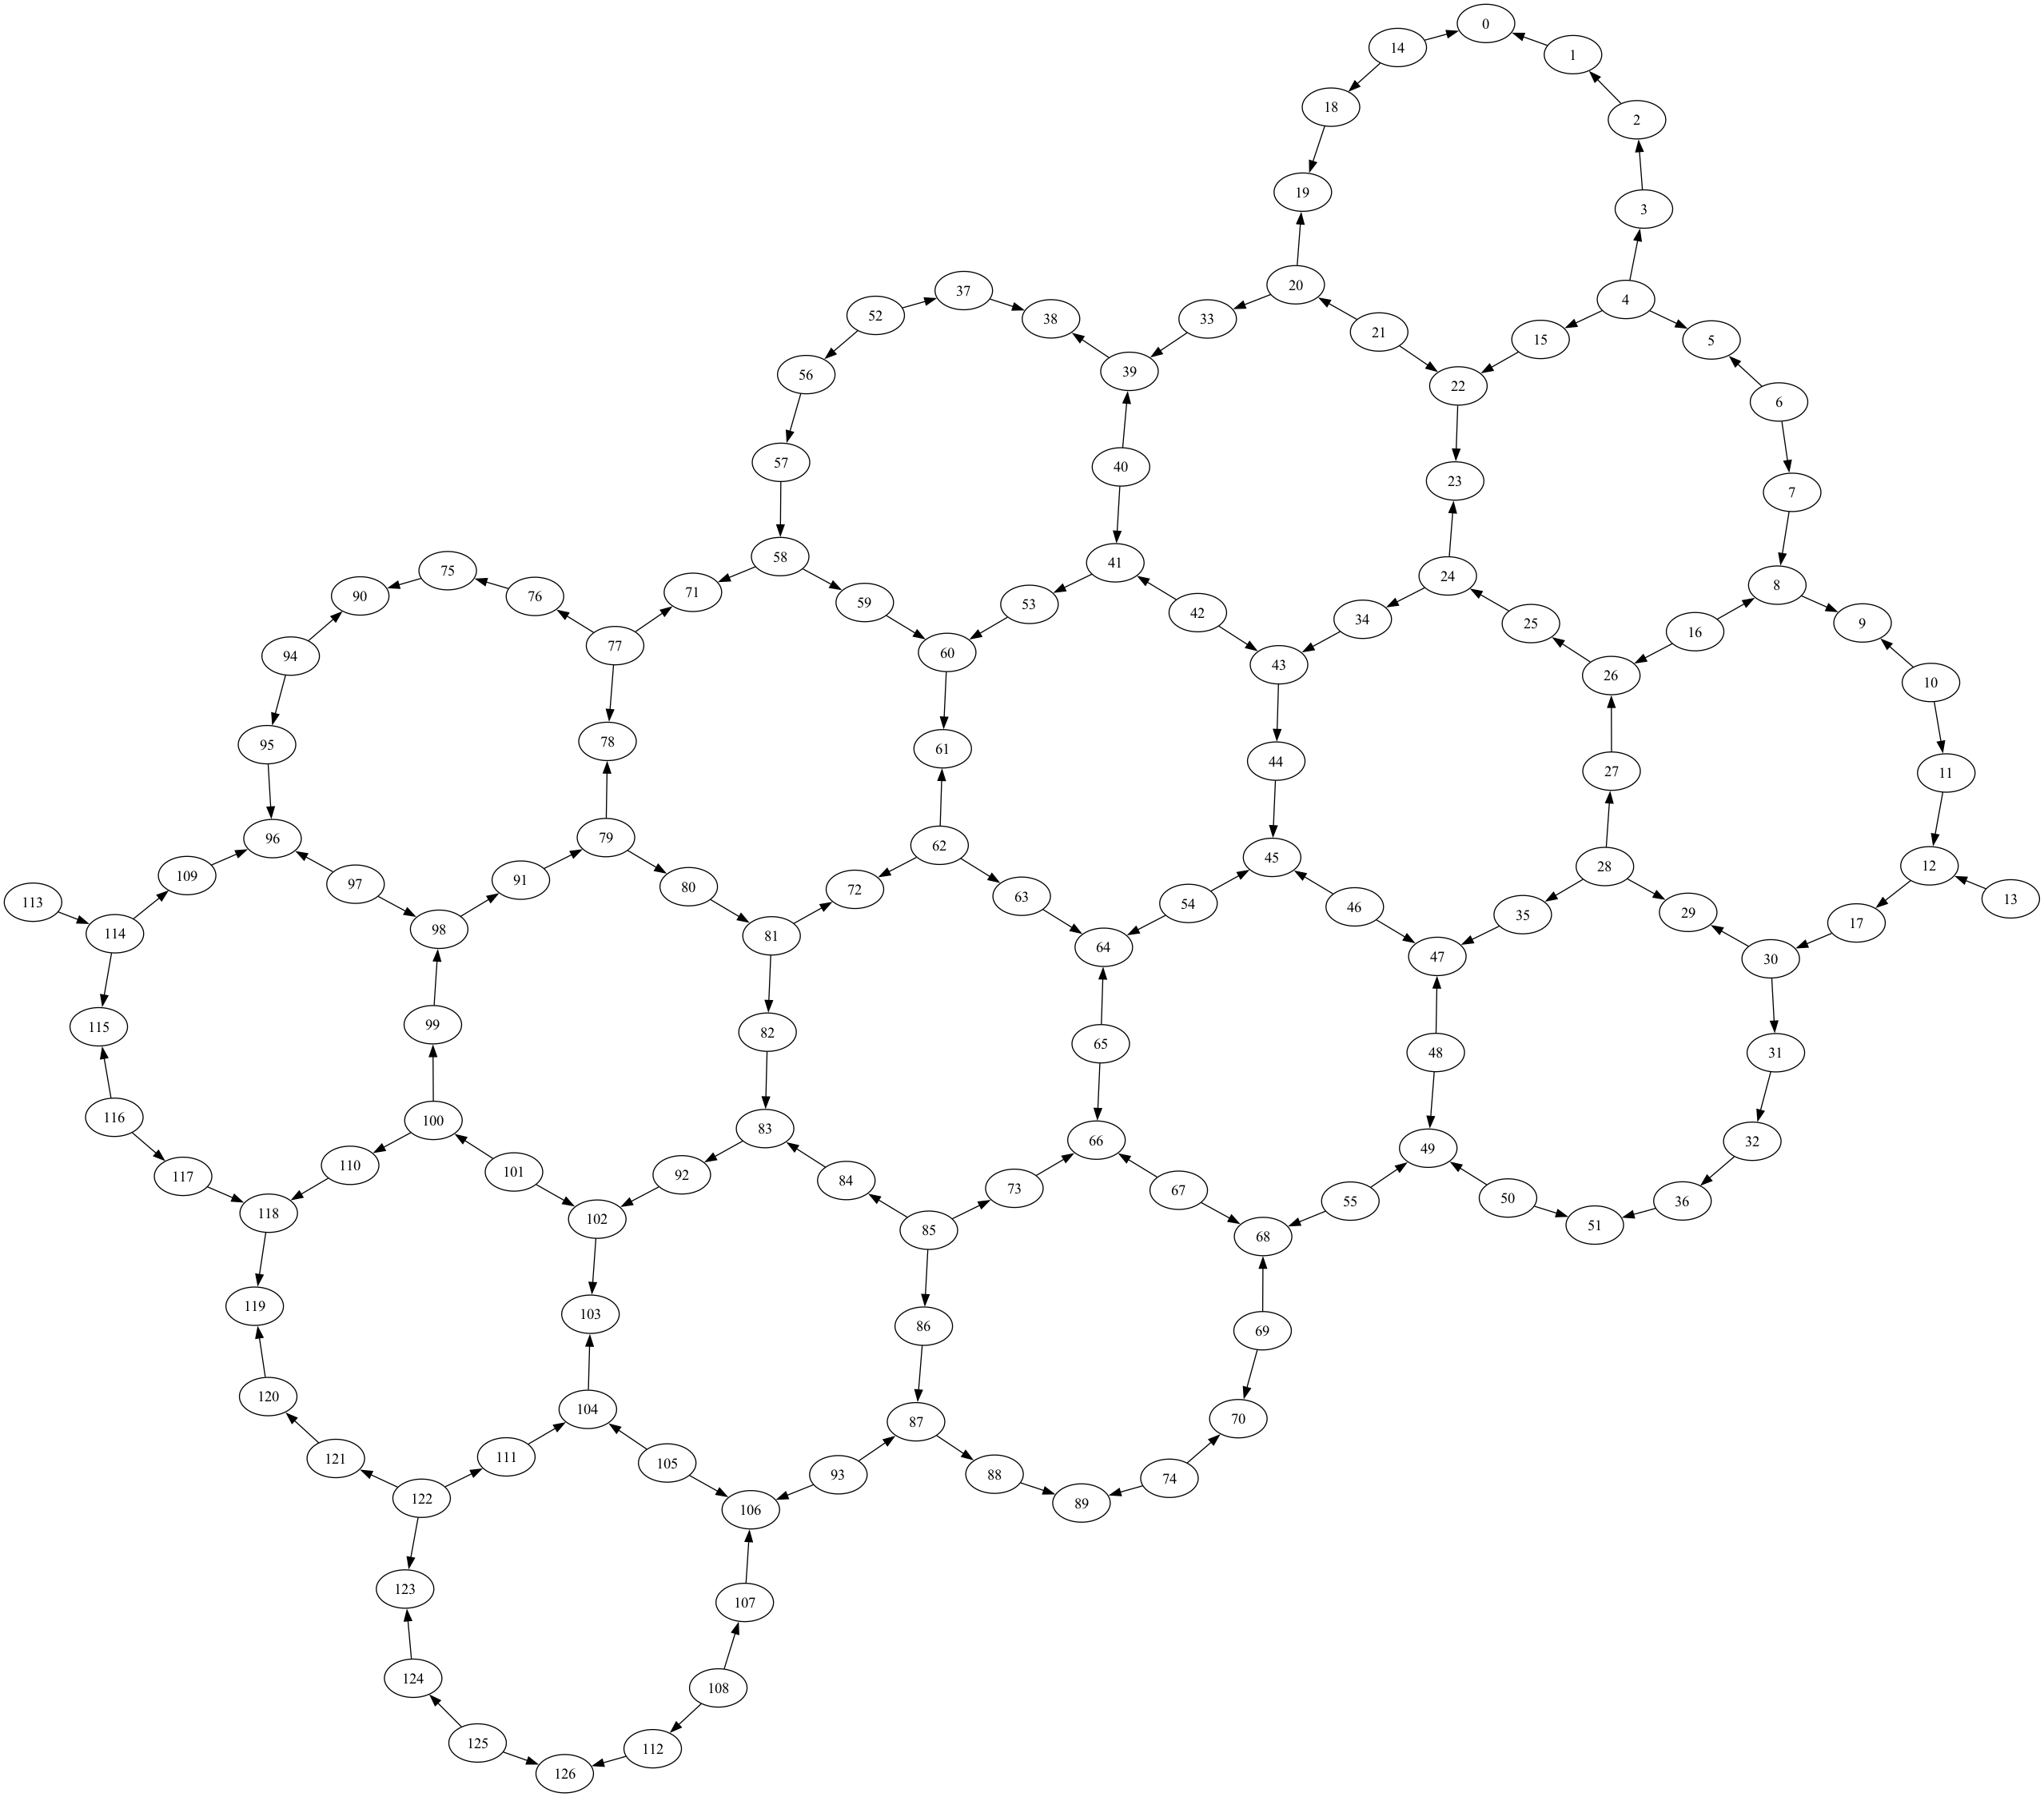

In [7]:
# This function requires that Graphviz is installed. If you need to install Graphviz you can refer to:
# https://graphviz.org/download/#executable-packages for instructions.
try:
    fig = backend.coupling_map.draw()
except RuntimeError as ex:
    print(ex)
fig

## 3. 量子ビットのプロパティ

Eagle デバイスには 127 量子ビットがあります。特性をいくつか取得してみましょう。


In [8]:
for qn in range(backend.num_qubits):
    if qn >= 5:
        break
    print(f"{qn}: {backend.qubit_properties(qn)}")

0: QubitProperties(t1=0.000292034087560393, t2=5.3456867360362344e-05, frequency=4721903631.949188)
1: QubitProperties(t1=0.00033950165515210127, t2=0.00039862146879251906, frequency=4815140551.859664)
2: QubitProperties(t1=0.0001893656586259208, t2=0.0001490591570503984, frequency=4609660452.383167)
3: QubitProperties(t1=0.00023199942551193687, t2=0.0002690041224425773, frequency=4875544904.133222)
4: QubitProperties(t1=0.0002808657906566358, t2=0.00024100290228637778, frequency=4818195916.209471)


量子ビットの T1 時間の中央値を計算してみましょう。この結果を [IBM Quantum Platform](https://quantum.cloud.ibm.com/computers) 上のデバイスに対して示された結果と比較してみてください。

In [9]:
t1s = [backend.qubit_properties(qq).t1 for qq in range(backend.num_qubits)]
f"Median T1: {(statistics.median(t1s)*10**6):.2f} \u03bcs"

'Median T1: 228.90 μs'

### 3.1 演習

量子ビットの T2 時間の中央値を計算します。自分で確認できるようにコードが以下に追加されています。


In [10]:
# Your code here

t2s = [backend.qubit_properties(qq).t2 for qq in range(backend.num_qubits)]
f"Median T2: {(statistics.median(t2s)*10**6):.2f} \u03bcs"

'Median T2: 135.87 μs'

### 3.2 ゲートエラーと読み出しエラー

次に、ゲートエラーに目を向けます。まず、ターゲット・インスタンスのデータ構造を調べます。キーが演算名である辞書になっています。


In [11]:
target = backend.target
target.keys()

dict_keys(['ecr', 'x', 'id', 'measure', 'delay', 'rz', 'reset', 'sx'])

その値も辞書です。'sx'　演算の値(辞書)の項目をいくつか見てみましょう。

In [12]:
for i, qq in enumerate(target["sx"]):
    if i >= 5:
        break
    print(i, qq, target["sx"][qq])

0 (0,) InstructionProperties(duration=6e-08, error=0.00021078975905076041)
1 (1,) InstructionProperties(duration=6e-08, error=8.106347000244111e-05)
2 (2,) InstructionProperties(duration=6e-08, error=0.0001892776721271782)
3 (3,) InstructionProperties(duration=6e-08, error=0.000152876721043599)
4 (4,) InstructionProperties(duration=6e-08, error=0.002994344275735296)


'ecr' と 'measure' 演算について同じことをしてみましょう。

In [13]:
for i, edge in enumerate(target["ecr"]):
    if i >= 5:
        break
    print(i, edge, target["ecr"][edge])

0 (1, 0) InstructionProperties(duration=6.6e-07, error=0.003287264393191658)
1 (2, 1) InstructionProperties(duration=6.6e-07, error=0.0043295409327960555)
2 (3, 2) InstructionProperties(duration=6.6e-07, error=0.007540236778437626)
3 (4, 3) InstructionProperties(duration=6.6e-07, error=0.003984654372579111)
4 (4, 5) InstructionProperties(duration=6.6e-07, error=0.005335475985054017)


In [14]:
for i, qq in enumerate(target["measure"]):
    if i >= 5:
        break
    print(i, qq, target["measure"][qq])

0 (0,) InstructionProperties(duration=1.3e-06, error=0.0321044921875)
1 (1,) InstructionProperties(duration=1.3e-06, error=0.028076171875)
2 (2,) InstructionProperties(duration=1.3e-06, error=0.0123291015625)
3 (3,) InstructionProperties(duration=1.3e-06, error=0.0357666015625)
4 (4,) InstructionProperties(duration=1.3e-06, error=0.0277099609375)


ご覧のとおり、読み出しエラーは 2 量子ビット演算のエラーよりも大きい傾向があり、2 量子ビット演算のエラーは 1 量子ビット演算よりも大きい傾向があります。

データ構造を理解したので、'sx' ゲートと 'ecr' ゲートのエラーの中央値を計算する準備ができました。もう一度、結果を [IBM Quantum Platform](https://quantum.cloud.ibm.com/computers) 上のデバイスに対して示されている結果と比べてみてください。

In [15]:
sx_errors = [inst_prop.error for inst_prop in target["sx"].values()]
f"Median SX error: {(statistics.median(sx_errors)):.3e}"

'Median SX error: 2.420e-04'

In [16]:
ecr_errors = [inst_prop.error for inst_prop in target["ecr"].values()]
f"Median ECR error: {(statistics.median(ecr_errors)):.3e}"

'Median ECR error: 6.772e-03'

## 4. 付録



Qiskit の人気のある機能は、視覚化です。回路ビジュアライザー、状態および分布ビジュアライザー、およびターゲットビジュアライザーがあります。最初の 2 つは、以前の jupyter notebook ですでに使用しています。ターゲットビジュアライザーのいくつかの機能を使用してみましょう。

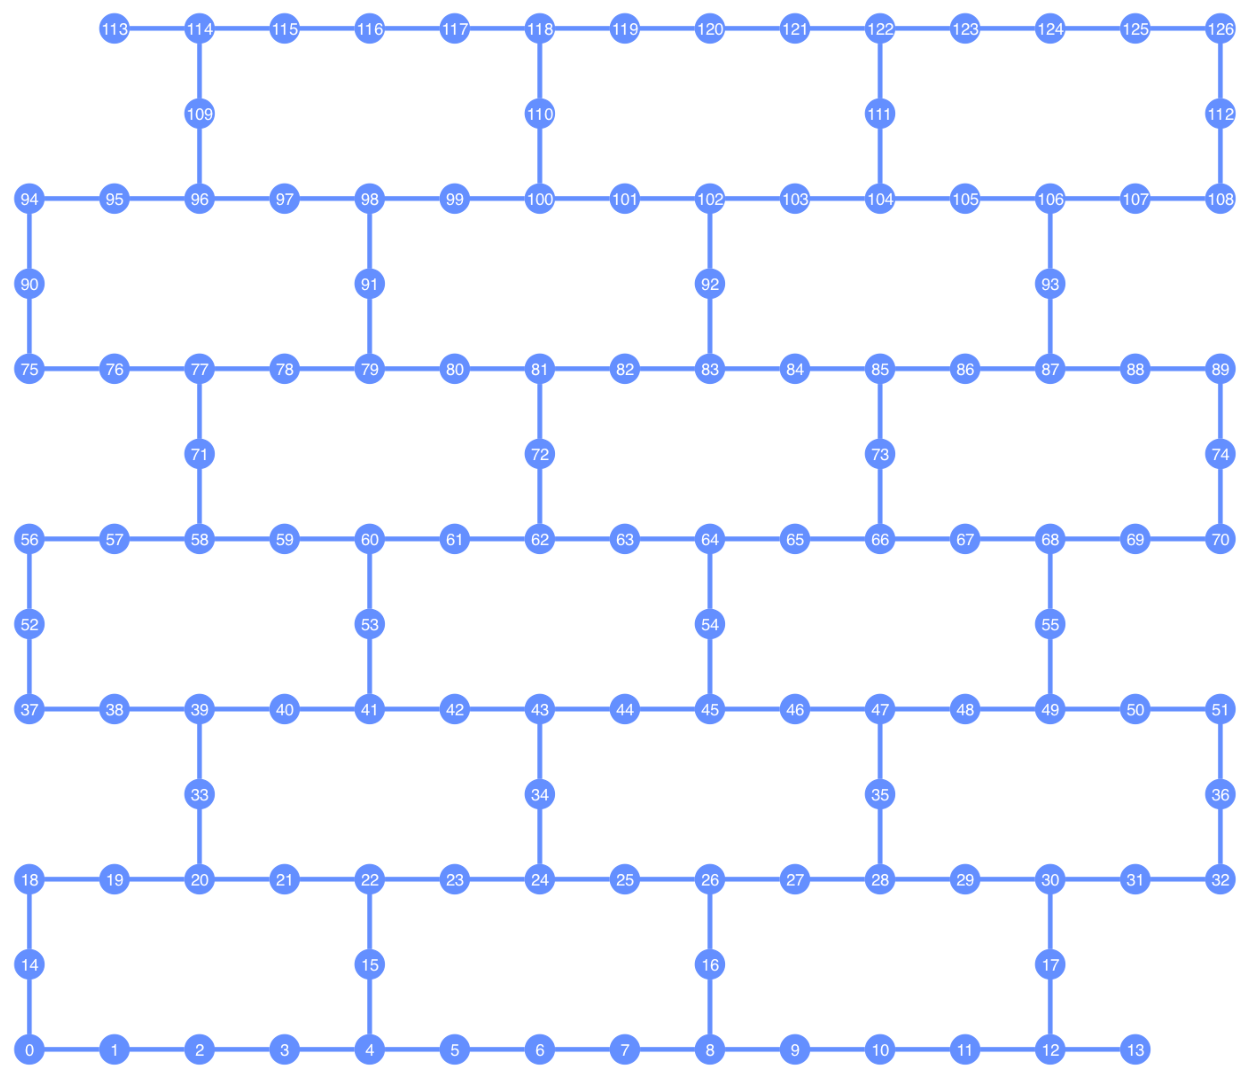

In [17]:
from qiskit.visualization import plot_gate_map

plot_gate_map(backend, font_size=14)

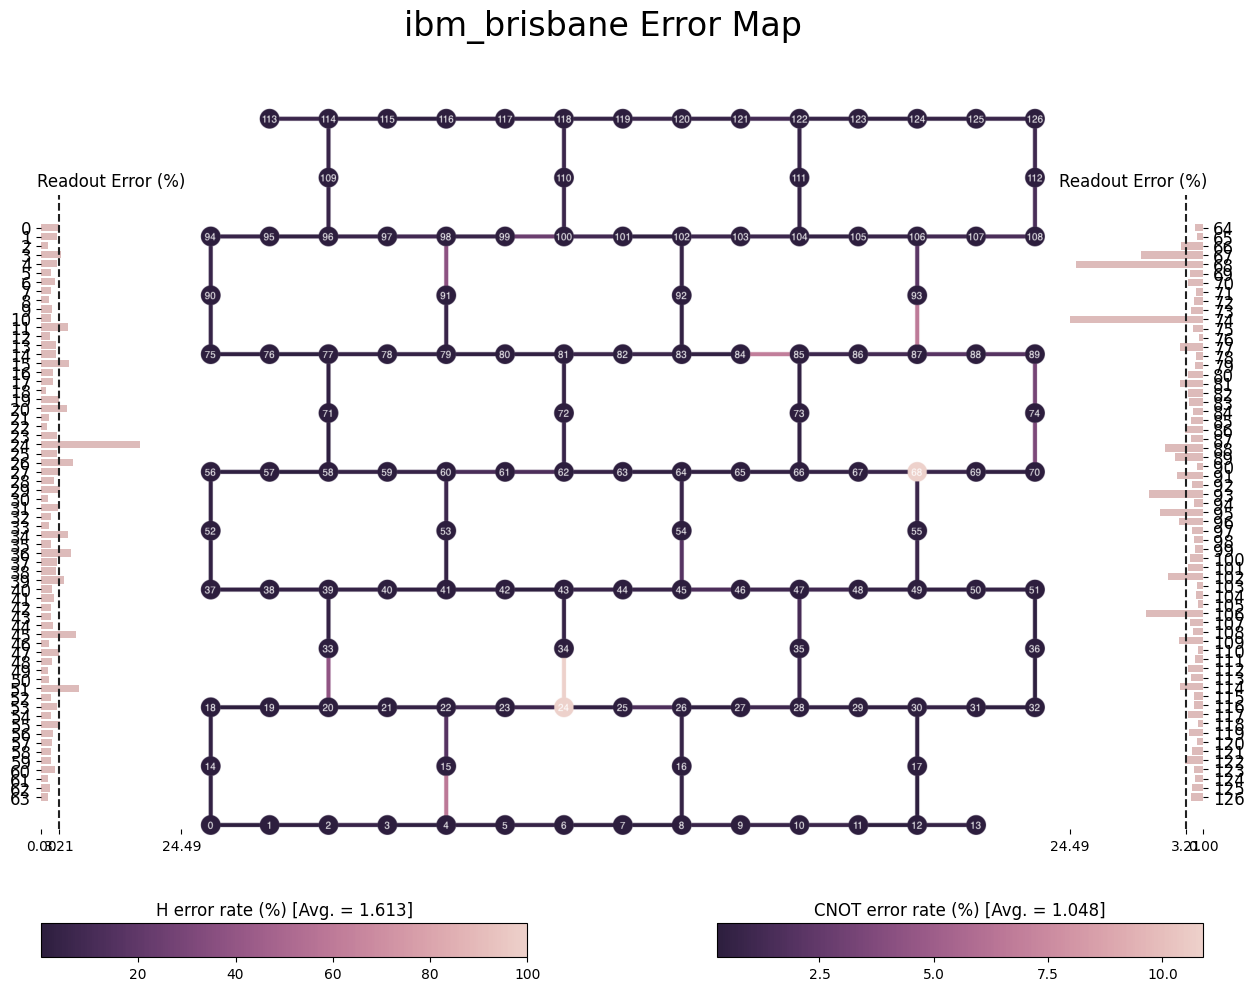

In [18]:
from qiskit.visualization import plot_error_map

plot_error_map(backend)

In [19]:
# Check Qiskit version
import qiskit

qiskit.__version__

'2.1.2'

© IBM Corp., 2017-2025